In [1]:
from src.plot_utils import plot_scatter,plot_map
import os,glob,cmaps,sys,re
import hydroeval as he
import numpy as np
from pyogrio import read_dataframe
import pandas as pd
import pickle
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.feature as cf
import matplotlib.pyplot as plt
import multiprocessing as mp
import matplotlib as mpl
import cartopy.crs as ccrs
from src.ale import _get_centres
from scipy.stats import pearsonr
import scipy.stats as stats
import pymannkendall as mk
from matplotlib.colors import LogNorm
import matplotlib.font_manager as font_manager
from scipy.interpolate import interp1d
font_manager.fontManager.addfont(os.environ['DATA']+'/fonts/Helvetica/Helvetica.ttf')
font_manager.fontManager.addfont(os.environ['DATA']+'/fonts/Helvetica/Helvetica-Bold.ttf')
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=24)

palette = {'tropical':'#F8D347',
           'dry':'#C7B18A',
           'temperate':"#65C2A5",
           'cold':"#a692b0",
#            'polar':"#B3B3B3"
          }

In [15]:
diff_Qmin7 = pd.read_csv('../results/sensitivity_+010urban_diff_in_percentage_xgb_Qmin7_seasonal4_multi_MSWX_meteo_MSWEP_GLEAM_noHydroSig_addNewAttr.csv')
diff_Qmax7 = pd.read_csv('../results/sensitivity_+010urban_diff_in_percentage_xgb_Qmax7_seasonal4_multi_MSWX_meteo_MSWEP_GLEAM_noHydroSig_addNewAttr.csv')

diff_Qmin7_ave = diff_Qmin7.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity'])['diff+010urban'].agg(
    diff = lambda x:x.mean(),
    p = lambda x: stats.ttest_1samp(x, 0, alternative='two-sided').pvalue
).reset_index()
diff_Qmax7_ave = diff_Qmax7.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity'])['diff+010urban'].agg(
    diff = lambda x:x.mean(),
    p = lambda x: stats.ttest_1samp(x, 0, alternative='two-sided').pvalue
).reset_index()


fraction of significant gauges: 96.28966833691243
average diff of significant gauges: 20.76778769810213
9.524238501696153 13.974195357612086
48.06500732137859 64.98431532646048
TtestResult(statistic=-43.71100121484135, pvalue=0.0, df=8380.0) -2.758221509754656
fraction of significant gauges: 90.25524809160305
average diff of significant gauges: 5.285815893753778
-0.9484842066188586 11.181924697660175
20.130673863549912 29.281591916027743
TtestResult(statistic=-47.70013292126533, pvalue=0.0, df=8382.0) -1.8852644099336342
cold TtestResult(statistic=-19.94375089713252, pvalue=8.630374117247388e-84, df=3406.0)
temperate TtestResult(statistic=-18.91069361213156, pvalue=6.879918584750962e-77, df=4631.0)
dry TtestResult(statistic=0.0, pvalue=1.0, df=1560.0)
tropical TtestResult(statistic=-18.102349798761068, pvalue=2.1201406499477193e-66, df=1500.0)
cold TtestResult(statistic=-28.775225456427332, pvalue=7.678995201334521e-162, df=3145.0)
temperate TtestResult(statistic=-23.282007426181533, p

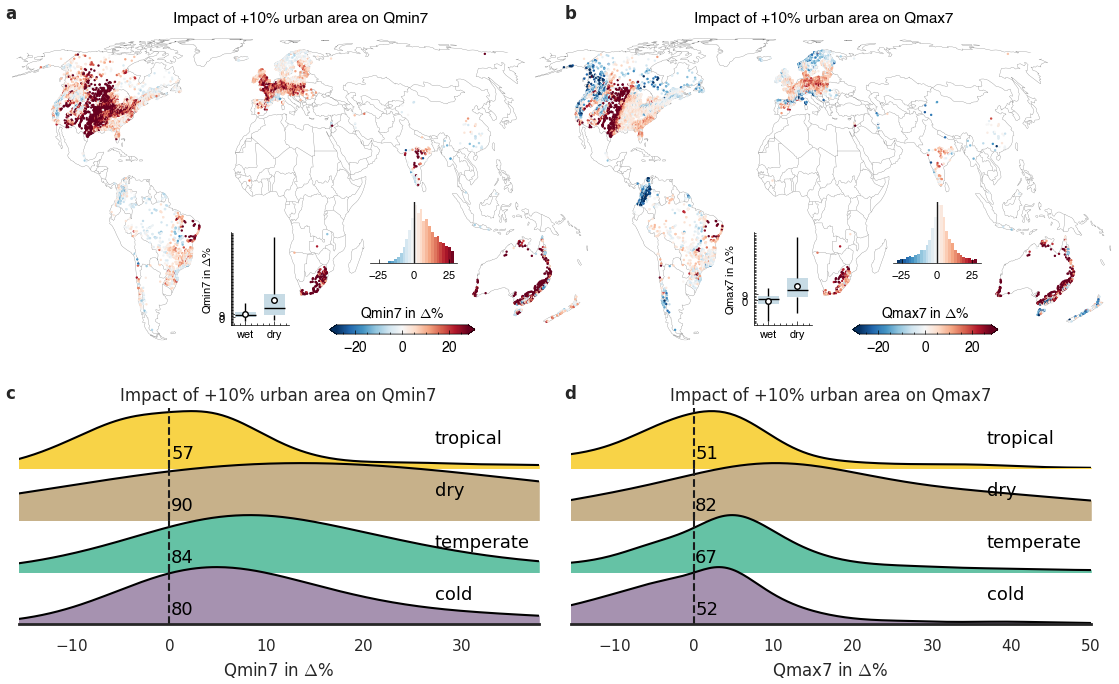

In [17]:
# Revert back plotting style
plt.rcParams.update(plt.rcParamsDefault)  # Reset to default Matplotlib settings
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')

# Re-enable inline plotting for Jupyter
%matplotlib inline

def compute_effsize(expGroup, controlGroup, eftype = 'cohen'):
    n1, n2 = len(expGroup), len(controlGroup)
    MAD1 = 1.4826 * np.median(np.abs(expGroup-np.median(expGroup)))
    MAD2 = 1.4826 * np.median(np.abs(controlGroup-np.median(controlGroup)))
    pooled_std = np.sqrt(((n1 - 1) * MAD1 ** 2 + (n2 - 1) * MAD2 ** 2) / (n1 + n2 - 2))
    if eftype == 'cohen':
        # d = np.mean(expGroup - controlGroup) / np.sqrt((MAD1**2+MAD2**2)/2)
        # d = np.mean(expGroup - controlGroup) / pooled_std
        d = (np.mean(expGroup) - np.mean(controlGroup)) / np.std(expGroup)
    elif eftype == 'glass':
        d = (np.mean(expGroup) - np.mean(controlGroup)) / MAD2
    return d

fig, ax1 = plt.subplots(figsize = (8, 4), subplot_kw = {'projection':ccrs.EqualEarth()})
ax2 = ax1.inset_axes([.9, 0, 1, 1], projection = ccrs.EqualEarth())
ax2.set_facecolor('none')
for i,name in enumerate(['Qmin7','Qmax7']):
    ax = eval('ax'+str(i+1))
    df = eval('diff_'+name+'_ave')
    lons = df.ohdb_longitude.values
    lats = df.ohdb_latitude.values
    vals = df['diff'].values

    vmin, vmax, vind = -28, 28, 2
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)
    if i == 0:
        title = 'Impact of +10% urban area on Qmin7'
    else:
        title = 'Impact of +10% urban area on Qmax7'
    label = f'{name} in $\Delta$%'
    _, ras = plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, norm = norm, fontSize = 11, size = 3)
    # add colorbar
    cax = ax.inset_axes([.55, .02, 0.25, .03])
    cbar = plt.colorbar(ras, cax = cax, orientation = 'horizontal', extend = 'both')
    cax.tick_params(labelsize = 10)
    cax.set_title(label, size = 10, pad = 5)
    # add boxplot to show the impact for dry (AI<1) and wet (AI>1) catchments
    df['tmp'] = np.where(df['aridity']>0.65, 'wet', 'dry')
    
    ttest = stats.ttest_ind(df.loc[df.tmp=='wet','diff'].values, df.loc[df.tmp=='dry','diff'].values)
    D = compute_effsize(df.loc[df.tmp=='wet','diff'].values, df.loc[df.tmp=='dry','diff'].values)
    
    print('fraction of significant gauges:', df.loc[df.p<=0.05,:].shape[0] / df.shape[0] * 100)
    print('average diff of significant gauges:', df.loc[df.p<=0.05,'diff'].mean())
    print(df.loc[df.tmp=='wet','diff'].mean(), df.loc[df.tmp=='wet','diff'].std())
    print(df.loc[df.tmp=='dry','diff'].mean(), df.loc[df.tmp=='dry','diff'].std())
    print(ttest, D)
    
    axin = ax.inset_axes([0.38, .05, .1, .3])
    sns.boxplot(df.loc[df.p<=0.01,:], 
                x = 'tmp', y = 'diff', ax = axin, 
                showfliers = False, width = .7, 
                whis = [2.5, 97.5],
                color = '#c2dcea',
                showmeans = True,
                capprops = {'linewidth': 0},
                boxprops={'edgecolor': 'none'},  # No edge line
                meanprops={'marker': 'o',
                       'markerfacecolor': 'white',
                       'markeredgecolor': 'black',
                       'markersize': '4'},
                medianprops={'color': 'black', 'linewidth': 1},  # Black median line
                whiskerprops={'color': 'black', 'linewidth': 1},  # Black whiskers
               )
    axin.set_facecolor('none')
    axin.set_yticks([0,9])
    axin.set_xlabel(None)
    axin.set_ylabel(f'{name} in $\Delta$%', fontsize = 8)
    axin.tick_params(labelsize = 8,  which='both', top = False, right = False)
    axin.spines["top"].set_visible(False) 
    axin.spines["right"].set_visible(False) 

# ridge plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

# Parameters for ridge plots
vertical_step = 0.13  # Vertical spacing between ridges
axes_height = 0.15     # Height of each distribution's axes
left_pos = 0.16        # Left boundary for left plot
right_pos = .85      # Left boundary for right plot
plot_width = 0.65      # Width of each ridge plot

# Utility function to create and plot ridge axes
def create_ridge_plot(df, position, x_range, name):
    axes = []
    for i, climate in enumerate(df.climate_label.unique()):
        # Create axes for current distribution
        ax_bottom = -0.6 + i * vertical_step
        ax = fig.add_axes([position, ax_bottom, plot_width, axes_height], zorder = 10 - i)
        axes.append(ax)
        
        print(climate, stats.ttest_ind(df.loc[df.climate_label==climate,'diff'].values, 
                              df.loc[df.climate_label=='dry','diff'].values, alternative='two-sided'))
        # Compute KDE
        sns.kdeplot(data = df.loc[df.climate_label==climate,:], 
                    x = 'diff', 
                    fill = True, 
                    hue = 'climate_label',
                    alpha = 1, 
                    ax = ax,
                    palette = palette,
                    legend = False,
                    clip = x_range)
        sns.kdeplot(data = df.loc[df.climate_label==climate,:], 
                    x = 'diff', 
                    color = 'black',
                    ax = ax,
                    palette = palette,
                    clip = x_range)
        ax.text(0.8, .5, climate, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        ax.axvline(x=0, color='k', linestyle='dashed', linewidth=1.5)
        ax.set_ylabel(None)
        
        # add fraction symbol with positive value
        frac = df.loc[(df.climate_label==climate)&(df['diff']>0),:].shape[0] / df.loc[(df.climate_label==climate),:].shape[0] * 100
        frac = int(frac)
        ax.text(0.2, axes_height/3*2, str(frac), color='black', fontsize=13,
                ha="left", va="bottom", transform=ax.get_xaxis_transform(), zorder = 10)
        
        # Remove unnecessary elements
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xlim(x_range)
        
        # Only show x-axis on the bottom plot
        if i != 0:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            ax.set_xlabel(None)
            
    # Set common x-axis for the bottom plot
    axes[0].spines['bottom'].set_visible(True)
    axes[0].xaxis.set_major_locator(ticker.AutoLocator())
    axes[0].set_xlabel(f'{name} in $\Delta$%')
    return axes

# Create both ridge plots
x_range = (-15.5, 38)  # Shared x-axis range
left_axes = create_ridge_plot(diff_Qmin7_ave.loc[diff_Qmin7_ave.p<=0.01,:], left_pos, x_range, 'Qmin7')
x_range = (-15.5, 50)
right_axes = create_ridge_plot(diff_Qmax7_ave.loc[diff_Qmax7_ave.p<=0.01,:], right_pos, x_range, 'Qmax7')

# add title
left_axes[-1].set_title('Impact of +10% urban area on Qmin7')
right_axes[-1].set_title('Impact of +10% urban area on Qmax7')   

# add subplot order
fig.text(.15, .95, 'a', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.85, .95, 'b', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.15,  0, 'c', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.85,  0, 'd', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)

fig.savefig('../picture/map_sensitivity_ridgeplot.png', dpi = 600)

# Revert back plotting style
plt.rcParams.update(plt.rcParamsDefault)  # Reset to default Matplotlib settings
plt.style.use(['science','nature','no-latex']) # require install SciencePlots
plt.rc('font', size = 12, family = 'Helvetica')

# Re-enable inline plotting for Jupyter
%matplotlib inline